In [10]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import torch
from calflops import calculate_flops
import sophius.utils as utils
import sophius.dataload as dload
from sophius.modelgen import ConvModelGenerator
from sophius.train import train_express_gpu
import torchvision.datasets as dset
import torchvision.transforms as T
from sophius.encode import Encoder
from sophius.utils import calc_model_flops, hash_dict
import sqlite3
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import random
from sophius.train import train_on_gpu_ex
normalize = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),    
])
cifar10 = dset.CIFAR10('../data/CIFAR10', train=True, download=True, transform=normalize)
cifar_gpu = dload.cifar_to_gpu(cifar10)

encoder = Encoder()

Files already downloaded and verified


In [27]:
from sophius.estimate import LSTMRegressor

estimator = torch.load('../data/models/estimator_v1.pth').cpu()

def estimate_val_acc(model_tmpl):
    t = torch.tensor(encoder.model2vec(model_tmpl), dtype=torch.float32)
    return estimator.cpu()(t).item()

Conv2d       (192, 33, 33)  (6, 6)   (1, 1)  
ReLU         (192, 33, 33) 
MaxPool2d    (192, 34, 34)  (2, 2)   (1, 1)  
AvgPool2d    (192, 18, 18)  (4, 4)   (2, 2)  
Conv2d       (32, 7, 7)     (2, 2)   (3, 3)  
LeakyReLU    (32, 7, 7)     (0.001) 
BatchNorm2d  (32, 7, 7)    
AvgPool2d    (32, 4, 4)     (4, 4)   (2, 2)  
Flatten      512           
Linear       10            



Loss 109.339: 100%|██████████| 50/50 [05:31<00:00,  6.62s/it]


val_acc: 0.712 train_acc: 0.758
val_acc* 0.666


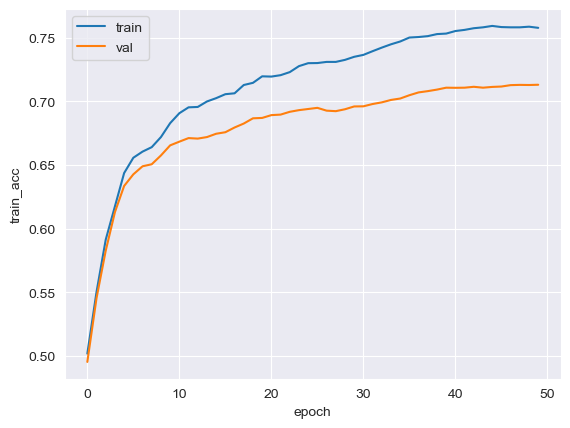

In [33]:
model_gen = ConvModelGenerator(
    in_shape=(3, 32, 32), 
    out_shape=10, 
    conv_num=3, 
    lin_num=1,
)
model_tmpl = model_gen.generate_model_tmpl()
model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
print(model_tmpl)

val_acc_threshold = 0.6

train_params = {
    'val_size': 10000,
    'batch_size': 256,
    'num_epoch': 50,
    'random_seed':42,
    'optimizer': 'AdamW',
    'opt_params': {
        'lr': 1e-3,
    },
    'scheduler': 'ExponentialLR',
    'sch_params': {
        'gamma': 0.95,
    },
}

res = train_on_gpu_ex(
    model=model,
    dataset=cifar_gpu,
    verbose=True,
    **train_params,
)
print('val_acc* %.3f' % (estimate_val_acc(model_tmpl)))

sns.lineplot(res, x='epoch', y='train_acc', label='train')
sns.lineplot(res, x='epoch', y='val_acc', label='val');

0.5292797684669495

In [34]:
import sqlite3
from sophius.utils import hash_dict

exp_id = 0
with sqlite3.connect('../data/models.db') as conn:
    try:
        exp_id = conn.execute('SELECT COUNT(*) FROM test_experiments').fetchone()[0]
    except:
        pass
    exp_params = {**train_params, **{'in_shape': (3, 32, 32), 'out_shpape': 10}}
    
    df = pd.DataFrame([exp_params], index=[exp_id])
    exp_hash = hash_dict(exp_params)
    df['hash'] = exp_hash
    df.index.name = 'id'
    if exp_id == 0:
        df.astype(str).to_sql('test_experiments', conn, if_exists='append')
    else:
        # check if experiment exists
        res = conn.execute('SELECT id FROM test_experiments WHERE hash == ?', (exp_hash,)).fetchone()
        if res:
            print('Experiment exists')
            print(exp_params)
            exp_id = res[0]
        else:
            print('Creating new experiment')
            print(exp_params)
            df.astype(str).to_sql('test_experiments', conn, if_exists='append')    
exp_id

0

In [13]:
# run stats - run_id, run params
# run_models run_id -> model_id 
# model stats model_id, hash, flops, batch_size
# model_per_epoch stats model_id, 

In [ ]:
model_gen = ConvModelGenerator((3, 32, 32), 10, conv_num=3, lin_num=1)
estimator = torch.load('../data/models/estimator_v1.pth')
val_acc_threshold = 0.6

for i in tqdm(range(10)):
    model_tmpl = model_gen.generate_model_tmpl()    
    model = model_tmpl.instantiate_model().type(torch.cuda.FloatTensor)
    
    est_val_acc = estimate_val_acc(model_tmpl) 
    if est_val_acc < val_acc_threshold:
        print('Skip estimated', est_val_acc)
        continue
    
    epoch_results = train_on_gpu_ex(
        model=model,
        dataset=cifar_gpu,
        verbose=False,
        **train_params,
    )
    
    model_id = 0
    with sqlite3.connect('../data/models.db') as conn:
        try:
            model_id = conn.execute('SELECT COUNT(*) FROM test_models').fetchone()[0]
        except:
            pass
        
    model_results = calc_model_flops(model, (3, 32, 32))
    model_results['id'] = model_id
    model_results['exp_id'] = exp_id
    model_results['hash'] = encoder.model2hash(model_tmpl)    
    model_results['val_acc'] = epoch_results.val_acc.iloc[-10:].mean()
    model_results['train_acc'] = epoch_results.train_acc.iloc[-10:].mean()
    model_results['time'] = epoch_results.time.iloc[-1]
    
    epoch_results['model_id'] = model_id
    epoch_results['exp_id'] = exp_id

    with sqlite3.connect('../data/models.db') as conn:
        df = pd.DataFrame([model_results]).set_index('id').astype(str)
        df.to_sql('test_models', conn, if_exists='append')
        
        epoch_results.to_sql('test_model_epochs', conn, if_exists='append', index=False)
        
#     # print(df.loc[i])

  0%|          | 0/10 [00:00<?, ?it/s]

Skip estimated 0.5236546397209167
